In [7]:
# path to your own data and coco file
train_data_dir = 'data/images/livecell_train_val_images'
train_coco = 'data/livecell_coco_train.json'

val_coco = 'data/livecell_coco_val.json'
test_coco = 'data/livecell_coco_test.json'

In [1]:
from src.dataset import myCOCODataset

train_data = myCOCODataset(train_data_dir, train_coco)

loading annotations into memory...
Done (t=8.02s)
creating index...
index created!


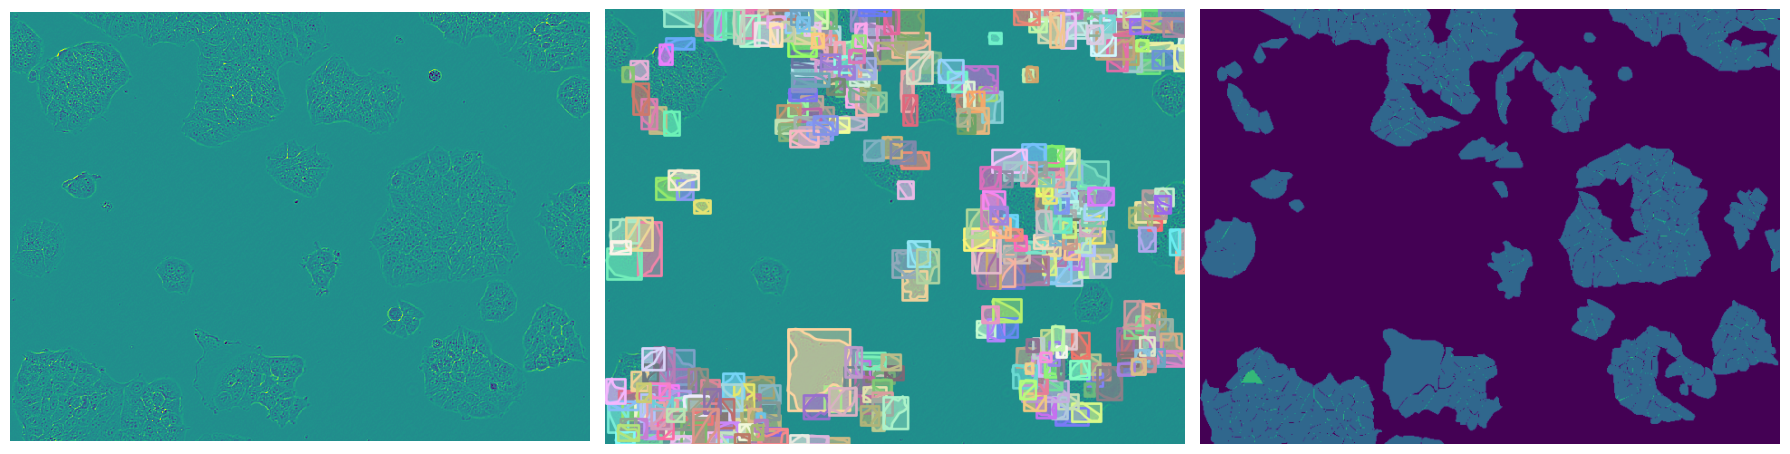

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_sample(dataset, index:int):
    figure, axes=plt.subplots(nrows=1,ncols=3,figsize=(18,12))
    for ax in axes:
        ax.set_axis_off()
    axes[0].imshow(dataset[index][0], interpolation='nearest')
    axes[1].imshow(dataset.visualize(index))
    axes[2].imshow(dataset.visualize(index, True))

    plt.tight_layout()
    plt.show()

plot_sample(train_data, 999)

```
images/
    ├── livecell_test_images
    |       └── <Cell Type>
    |               └── <Cell Type>_Phase_<Well>_<Location>_<Timestamp>_<Crop>.tif
    └── livecell_train_val_images
            └── <Cell Type>
```
Where `<Cell Type>` is each of the eight cell-types in LIVECell (A172, BT474, BV2, Huh7, MCF7, SHSY5Y, SkBr3, SKOV3). Wells `<Well>` are the location in the 96-well plate used to culture cells, `<Location>` indicates location in the well where the image was acquired, `<Timestamp>` the time passed since the beginning of the experiment to image acquisition and `<Crop>` index of the crop of the original larger image. An example image name is A172_Phase_C7_1_02d16h00m_2.tif, which is an image of A172-cells, grown in well C7 where the image is acquired in position 1 two days and 16 hours after experiment start (crop position 2).

In [10]:
import json

with open('/Users/danila_orlov/Downloads/0_train2percent.json', 'r') as f:
    data = json.load(f)
print(data.keys())
del data

dict_keys(['images', 'annotations', 'categories', 'info', 'licenses'])


In [8]:
import pandas as pd
import json

def get_df(json_path:str, data_type:str='images'):
    print(json_path)
    with open(json_path, 'r') as f:
        data = json.load(f)

    # print(data.keys())
    df = pd.DataFrame.from_dict(data[data_type])
    print(df.shape)
    if data_type == 'images':
        df['cell_type'] = df.file_name.apply(lambda x: x.split('_')[0])
        df['well'] = df.file_name.apply(lambda x: x.split('_')[2])
    return df

df = get_df(train_coco)
df.head()

data/livecell_coco_train.json
(3253, 6)


,id,width,height,file_name,original_filename,url,cell_type,well
0,1,704,520,BT474_Phase_A3_2_00d04h00m_3.tif,BT474_Phase_A3_2_00d04h00m_3.png,https://darwin.v7labs.com/api/images/870028/or...,BT474,A3
1,133,704,520,BT474_Phase_C3_2_02d12h00m_4.tif,BT474_Phase_C3_2_02d12h00m_4.png,https://darwin.v7labs.com/api/images/37512/ori...,BT474,C3
2,323,704,520,BT474_Phase_C3_1_01d16h00m_3.tif,BT474_Phase_C3_1_01d16h00m_3.png,https://darwin.v7labs.com/api/images/108155/or...,BT474,C3
3,498,704,520,BT474_Phase_C3_1_02d16h00m_4.tif,BT474_Phase_C3_1_02d16h00m_4.png,https://darwin.v7labs.com/api/images/108172/or...,BT474,C3
4,741,704,520,BT474_Phase_C3_1_04d00h00m_3.tif,BT474_Phase_C3_1_04d00h00m_3.png,https://darwin.v7labs.com/api/images/921711/or...,BT474,C3


In [14]:
(df.width.unique(), df.height.unique())

(array([704]), array([520]))

In [5]:
(df.original_filename.value_counts() > 1).sum() # original_filename is not unique?

65

In [7]:
(df.id.value_counts() > 1).sum() # id is unique ;)

0

In [19]:
# smaller train part
splits = [
    '/Users/danila_orlov/Downloads/0_train2percent.json',
    '/Users/danila_orlov/Downloads/1_train4percent.json',
    '/Users/danila_orlov/Downloads/2_train5percent.json',
    '/Users/danila_orlov/Downloads/3_train25percent.json',
    '/Users/danila_orlov/Downloads/4_train50percent.json'
]

for split in splits:
    df_temp = get_df(split)
    assert df_temp.shape == df[df.id.isin(df_temp.id.to_list())].shape, 'В сплите есть отсутсвующие в полном train_dataset изображения'

/Users/danila_orlov/Downloads/0_train2percent.json
(66, 6)
/Users/danila_orlov/Downloads/1_train4percent.json
(131, 6)
/Users/danila_orlov/Downloads/2_train5percent.json
(162, 6)
/Users/danila_orlov/Downloads/3_train25percent.json
(808, 6)
/Users/danila_orlov/Downloads/4_train50percent.json
(1624, 6)


In [26]:
# duplicate fnms in train
duplicates = df.original_filename.value_counts()[(df.original_filename.value_counts() > 1)].index.to_list()
df[df.original_filename.isin(duplicates)].sort_values(by='file_name').head()

,id,width,height,file_name,original_filename,url,cell_type,well
1291,627203,704,520,Huh7_Phase_A10_2_00d00h00m_1.tif,Huh7_Phase_A10_2_00d00h00m_1.png,https://darwin.v7labs.com/api/images/37605/ori...,Huh7,A10
1997,1029675,704,520,Huh7_Phase_A10_2_00d00h00m_1.tif,Huh7_Phase_A10_2_00d00h00m_1.png,https://darwin.v7labs.com/api/images/47483/ori...,Huh7,A10
1466,724219,704,520,Huh7_Phase_A10_2_00d00h00m_2.tif,Huh7_Phase_A10_2_00d00h00m_2.png,https://darwin.v7labs.com/api/images/37606/ori...,Huh7,A10
1751,1013993,704,520,Huh7_Phase_A10_2_00d00h00m_2.tif,Huh7_Phase_A10_2_00d00h00m_2.png,https://darwin.v7labs.com/api/images/47484/ori...,Huh7,A10
1929,1025582,704,520,Huh7_Phase_A10_2_00d00h00m_4.tif,Huh7_Phase_A10_2_00d00h00m_4.png,https://darwin.v7labs.com/api/images/47414/ori...,Huh7,A10


In [28]:
df[df.original_filename.isin(duplicates)].shape

(130, 8)

In [29]:
main_splits = ['data/livecell_coco_train.json', 'data/livecell_coco_val.json', 'data/livecell_coco_test.json']
unique_wells = []
for split in main_splits:
    df_temp = get_df(split)
    unique_wells.append(set(df_temp.well.unique()))

len(set.intersection(*unique_wells))

data/livecell_coco_train.json
(3253, 6)
data/livecell_coco_val.json
(570, 6)
data/livecell_coco_test.json
(1564, 6)


4

In [35]:
for i in range(len(main_splits)):
    print(dfs[i].shape, len(unique_wells[i]))

(655, 8) 21
(112, 8) 21
(700, 8) 9


In [31]:
# i'm thinking about completly removing wells that were in test set from train and val sets
# it's possible

main_splits = ['data/livecell_coco_train.json', 'data/livecell_coco_val.json', 'data/livecell_coco_test.json']

for split in main_splits[:2]:
    df_temp = get_df(split)
    df_temp = df_temp[~df_temp.well.isin(unique_wells[2])]
    print(df_temp.cell_type.nunique() > 7, df_temp.shape)

data/livecell_coco_train.json
(3253, 6)
True (2598, 8)
data/livecell_coco_val.json
(570, 6)
True (458, 8)


In [23]:
df_tmp=get_df('data/livecell_coco_test.json')
df_tmp.head()

data/livecell_coco_test.json
(1564, 6)


,id,width,height,file_name,original_filename,url,cell_type,well
0,101438,704,520,BT474_Phase_D3_1_04d04h00m_3.tif,BT474_Phase_D3_1_04d04h00m_3.png,https://darwin.v7labs.com/api/images/870104/or...,BT474,D3
1,101798,704,520,BT474_Phase_D3_2_03d04h00m_2.tif,BT474_Phase_D3_2_03d04h00m_2.png,https://darwin.v7labs.com/api/images/61733/ori...,BT474,D3
2,101943,704,520,BT474_Phase_D3_1_01d12h00m_4.tif,BT474_Phase_D3_1_01d12h00m_4.png,https://darwin.v7labs.com/api/images/921720/or...,BT474,D3
3,102143,704,520,BT474_Phase_D3_2_04d16h00m_1.tif,BT474_Phase_D3_2_04d16h00m_1.png,https://darwin.v7labs.com/api/images/37521/ori...,BT474,D3
4,102490,704,520,BT474_Phase_D3_2_00d12h00m_3.tif,BT474_Phase_D3_2_00d12h00m_3.png,https://darwin.v7labs.com/api/images/921792/or...,BT474,D3


In [27]:
df_tmp.groupby(by='cell_type').well.nunique()

cell_type
A172      1
BT474     1
BV2       1
Huh7      1
MCF7      1
SHSY5Y    1
SKOV3     2
SkBr3     1
Name: well, dtype: int64

In [28]:
df_tmp.groupby(by='cell_type').well.count()

cell_type
A172      152
BT474     168
BV2       152
Huh7      216
MCF7      184
SHSY5Y    176
SKOV3     340
SkBr3     176
Name: well, dtype: int64

In [30]:
# ids are unique
main_splits = ['data/livecell_coco_train.json', 'data/livecell_coco_val.json', 'data/livecell_coco_test.json']
unique_ids = []
for split in main_splits:
    df_temp = get_df(split)
    unique_ids.append(set(df_temp.id.unique()))

len(set.intersection(*unique_ids))

data/livecell_coco_train.json
(3253, 6)
data/livecell_coco_val.json
(570, 6)
data/livecell_coco_test.json
(1564, 6)


0

In [31]:
# file names are unique
main_splits = ['data/livecell_coco_train.json', 'data/livecell_coco_val.json', 'data/livecell_coco_test.json']
unique_file_names = []
for split in main_splits:
    df_temp = get_df(split)
    unique_file_names.append(set(df_temp.file_name.unique()))

len(set.intersection(*unique_file_names))

data/livecell_coco_train.json
(3253, 6)
data/livecell_coco_val.json
(570, 6)
data/livecell_coco_test.json
(1564, 6)


0

In [ ]:
# we cant remove data from test (only 9 wells) or we wont get all cell types represented in test split.
# We should delete date from train and val splits
# but first, let's check some distributions 

data/livecell_coco_train.json
(1018576, 7)
data/livecell_coco_val.json
(181610, 7)
data/livecell_coco_test.json
(462261, 7)


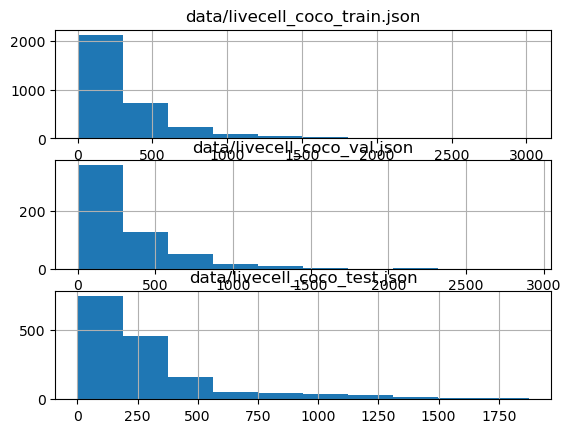

In [26]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3)

main_splits = ['data/livecell_coco_train.json', 'data/livecell_coco_val.json', 'data/livecell_coco_test.json']
unique_cell_types = []
for i, split in enumerate(main_splits):
    df_temp = get_df(split, 'annotations')
    df_temp.groupby(by='image_id').size().hist(ax=axes[i])
    axes[i].title.set_text(split)

plt.show()

# Exploring COCO

In [1]:
from src.dataset import get_data_loaders

data_dir = 'data/images/livecell_train_val_images'
train_coco = 'data/livecell_coco_train.json'
val_coco = 'data/livecell_coco_val.json'

train_loader, val_loader = get_data_loaders(data_dir, train_coco, val_coco, 1, 1)

loading annotations into memory...
Done (t=8.11s)
creating index...
index created!
loading annotations into memory...
Done (t=1.88s)
creating index...
index created!


In [4]:
# Build batch iterator
batch_iterator = iter(train_loader)

# Get images, targets in batch mode
#   images (torch.Tensor)  : tensor of person images of size: torch.Size([num_persons, 3, inp_dim, inp_dim])
#   keypoints (list)       : list of length equal to num_persons
images, keypoints = next(batch_iterator)
keypoints[0].keys()

dict_keys(['boxes', 'labels', 'masks', 'image_id', 'area', 'iscrowd'])

In [2]:
from src.model import get_model_instance_segmentation
import torch

model = get_model_instance_segmentation(2) # 2 classes; Only target class or background

# For Training
images,targets = next(iter(train_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
output = model(images,targets)   # Returns losses and detections
# For inference
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)           # Returns predictions

/Users/danila_orlov/miniforge3/envs/pytorch/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/Users/danila_orlov/miniforge3/envs/pytorch/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/Users/danila_orlov/miniforge3/envs/pytorch/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained_backbone' is deprecated since 0.13 and will be removed in 0.15, please use 'weights_backbone' instead.
  warnings.warn(
/Users/danila_orlov/miniforge3/envs/py

In [4]:
# For Training
images,targets = next(iter(train_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
output = model(images,targets)   # Returns losses and detections

In [5]:
# For inference
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)           # Returns predictions

In [6]:
output

{'loss_classifier': tensor(1.0178, grad_fn=<NllLossBackward0>),
 'loss_box_reg': tensor(0.1641, grad_fn=<DivBackward0>),
 'loss_mask': tensor(3.5164, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>),
 'loss_objectness': tensor(0.7124, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>),
 'loss_rpn_box_reg': tensor(0.0468, grad_fn=<DivBackward0>)}

In [7]:
predictions[0].keys()

dict_keys(['boxes', 'labels', 'scores', 'masks'])

In [8]:
predictions[0]['masks'].shape

torch.Size([2664, 1, 300, 400])

In [10]:
predictions[0]['masks'].shape

torch.Size([100, 1, 300, 400])

In [11]:
predictions[0]['boxes'].shape

torch.Size([100, 4])

In [12]:
predictions[0]['scores'].shape

torch.Size([100])

In [13]:
import torchvision

model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

/Users/danila_orlov/miniforge3/envs/pytorch/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/Users/danila_orlov/miniforge3/envs/pytorch/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [14]:
model.roi_heads.mask_predictor

MaskRCNNPredictor(
  (conv5_mask): ConvTranspose2d(256, 256, kernel_size=(2, 2), stride=(2, 2))
  (relu): ReLU(inplace=True)
  (mask_fcn_logits): Conv2d(256, 91, kernel_size=(1, 1), stride=(1, 1))
)

In [16]:
in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
hidden_layer = 256

In [17]:
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
MaskRCNNPredictor(in_features_mask,
                hidden_layer,
                2)

MaskRCNNPredictor(
  (conv5_mask): ConvTranspose2d(256, 256, kernel_size=(2, 2), stride=(2, 2))
  (relu): ReLU(inplace=True)
  (mask_fcn_logits): Conv2d(256, 2, kernel_size=(1, 1), stride=(1, 1))
)

In [2]:

from attrdict import AttrDict
import yaml
import os

config_pth = 'data_urls.yaml'

with open(config_pth) as f:
    config = yaml.safe_load(f)
    config = AttrDict(config)
print(config.images)

for split_url in config.annotations:
    print(split_url)

http://livecell-dataset.s3.eu-central-1.amazonaws.com/LIVECell_dataset_2021/images.zip
http://livecell-dataset.s3.eu-central-1.amazonaws.com/LIVECell_dataset_2021/annotations/LIVECell/livecell_coco_train.json
http://livecell-dataset.s3.eu-central-1.amazonaws.com/LIVECell_dataset_2021/annotations/LIVECell/livecell_coco_val.json
http://livecell-dataset.s3.eu-central-1.amazonaws.com/LIVECell_dataset_2021/annotations/LIVECell/livecell_coco_test.json


In [ ]:
TODO:
    fix dataset +- -- no need?
    train model on 5 epochs +-
    test loading model +-
    deploy model --
    train last time on fixed dataset - skrew it

In [10]:
from src.model import Predictor
from src.dataset import get_transform

model = Predictor('output/exp/weights/best.pth', thr=0.3, nms=0.5, device ='cpu')

In [17]:
import io
from PIL import Image

fh = 'data/images/livecell_train_val_images/A172_Phase_B7_1_00d00h00m_3.tif'
img = Image.open(fh, mode='r')

img_byte_arr = io.BytesIO()
img.save(img_byte_arr, format='PNG')
img_byte_arr = img_byte_arr.getvalue()

image_data = model.get_predict(img_byte_arr, 'mask')

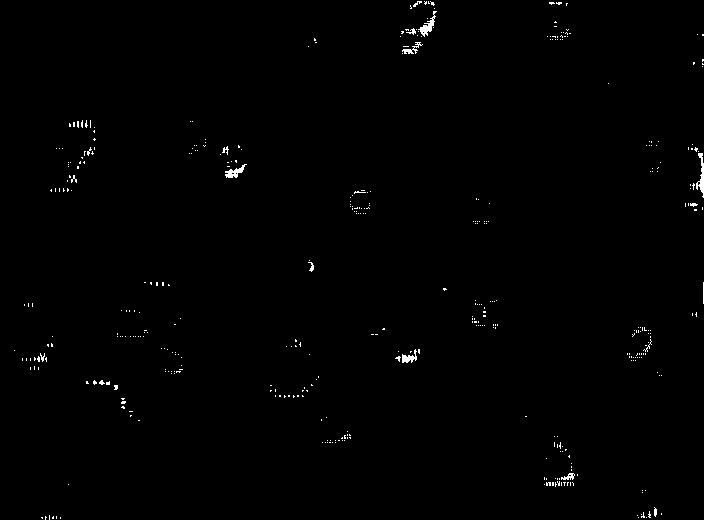

In [18]:
from PIL import Image
import io

image = Image.open(io.BytesIO(image_data))
image

In [ ]:
## check all shapes!!!!